In [1]:
# Do all necessary preprocessing, calling prepro.py
import utils
from utils import *
importlib.reload(utils)
from utils import *

In [2]:
# Load data
X, X_test_original, y = load_data() 
y = y.ravel()
scores = np.array([])
xtrain = X  # For andreas cross validation
ytrain = y

# Visualize PCA contributions

Sizes X, y: (4800, 1000) (4800,)


Text(0.5,1,'Explained Variance Ratio')

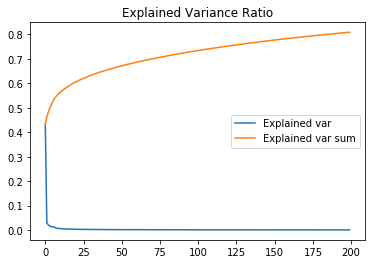

In [3]:
print("Sizes X, y:", X.shape, y.shape)
transformer = PCA(n_components=200)
xpca = transformer.fit_transform(X)
var_ratio = transformer.explained_variance_ratio_

# Plot
plt.figure()
plt.plot(var_ratio, label="Explained var")
plt.plot(np.cumsum(var_ratio), label="Explained var sum")
plt.legend()
plt.title("Explained Variance Ratio")


# Plot the variances of each column

Text(0.5,1,'Column Variance')

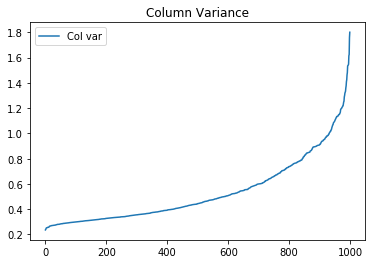

In [18]:
# Plot
plt.figure()
plt.plot(np.sort(np.var(X, axis=0)), label="Col var")
plt.legend()
plt.title("Column Variance")

# Now, do preprocessing, and then PCA

In [44]:
def prepro(X_, y_, X_test=None, y_test=None, threshold=0.3, k=800, n_estimators=200):
    if X_test is None:
        X_test = np.zeros_like(X_)
        y_test = np.zeros_like(y_)
    print("Original sizes X, y:", X_.shape, y_.shape)
    # Remove low variance things
    sel = VarianceThreshold(threshold=threshold)
    sel.fit(X_)
    X_highvar = sel.transform(X_)
    X_test_highvar = sel.transform(X_test)
    print("Size of X after removing low variance:", X_highvar.shape)

    # Standardize
    scaler = preprocessing.StandardScaler()
    X_std = scaler.fit_transform(X_highvar)
    X_test_std = scaler.transform(X_test_highvar)

    # Select top 800 using mutual info_classif o f_classif? 
    best = SelectKBest(mutual_info_classif, k=k)
    X_new = best.fit_transform(X_std, y_)
    X_test_new = best.transform(X_test_std)

    # Outlier Detection
    # Fit an isolation forest
    clf = IsolationForest(n_estimators=n_estimators)
    clf.fit(X_new)
    clf.decision_function(X_new)
    inlier_indices = np.where(clf.predict(X_new) == 1)[0]
    print("Size of inliers:", inlier_indices.shape)
    X_inliers = X_new[inlier_indices]
    y_inliers = y_[inlier_indices]
    X_test_inliers = X_test_new # Do not remove outliers from test dataset
    y_test_inliers = y_test
    print("Inliers shapes:", X_inliers.shape, y_inliers.shape)

    # PCA
    transformer = PCA(n_components=k)
    xpca_train = transformer.fit_transform(X_inliers)
    var_ratio_ = transformer.explained_variance_ratio_
    xpca_test = transformer.fit_transform(X_test_inliers)
    return X_inliers, y_inliers, X_test_inliers, y_test_inliers, var_ratio_

# X_in, y_in, _, __, var_ratio = prepro(X, y, threshold=0.3, k=100, n_estimators=200)
# # Plot
# plt.figure()
# plt.plot(var_ratio, label="Explained var")
# plt.plot(np.cumsum(var_ratio), label="Explained var sum")
# plt.legend()
# plt.title("Explained Variance Ratio")

# Try training a Balanced SVM on this

In [ ]:
# Try a nn Estimator with SMOTE

kf = KFold(n_splits=5, shuffle = True)

BMAC_means = np.array([])
BMAC_stds = np.array([])
BMAC_scores = np.array([])
for train_index, test_index in kf.split(xtrain):

    x_train = xtrain[train_index]
    x_test = xtrain[test_index]

    y_train = ytrain[train_index]
    y_test = ytrain[test_index]

    x_train, y_train, x_test, y_test, var_ratio = prepro(x_train, y_train, x_test, y_test, 
                                                        threshold=0.25, k=300, n_estimators=200)

    # Model to fit
    estimator = svm.SVC(class_weight='balanced')
    estimator.fit(x_train, y_train.ravel())
    pred = estimator.predict(x_test)
    BMAC = balanced_accuracy_score(y_test, pred)

    print("BMAC Score: ", BMAC)
    BMAC_scores = np.append(BMAC_scores, BMAC)
    
#     train_sizes, train_scores, valid_scores = learning_curve(estimator, x_train, y_train, train_sizes=[50, 80, 110], cv=5)

BMAC_means = np.append(BMAC_means, np.mean(BMAC_scores))
BMAC_stds = np.append(BMAC_stds, np.std(BMAC_scores))
#print(np.mean(BMAC_scores))
#print(np.std(BMAC_scores))

print("Scores:", BMAC_scores)
print("Mean Scores:", BMAC_means)
print("Std Scores:", BMAC_stds)

# Mean Scores: [0.67625076], cv=5:
#    estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                            hidden_layer_sizes=(150,150), random_state=1,
#                             activation='relu', learning_rate='constant', beta_1=0.9, 
#                               beta_2=0.999, learning_rate_init=0.001
#                           )

#  Scores: [0.66639015 0.6848148  0.70958482 0.69875664 0.65585182]
# Mean Scores: [0.68307965]
# Std Scores: [0.01985546]
    
# estimator = MLPClassifier(solver='lbfgs', alpha=1e-5,
#                        hidden_layer_sizes=(150,150), random_state=1,
#                         activation='relu', learning_rate='invscaling', beta_1=0.9, 
#                           beta_2=0.999, learning_rate_init=0.001, early_stopping=True,
#                           momentum=0.9, shuffle=True, epsilon=1e-08, 

#                       )

Original sizes X, y: (3840, 1000) (3840,)
Size of X after removing low variance: (3840, 995)
Size of inliers: (3456,)
Inliers shapes: (3456, 300) (3456,)
BMAC Score:  0.6742722930483708
Original sizes X, y: (3840, 1000) (3840,)
Size of X after removing low variance: (3840, 997)
Size of inliers: (3456,)
Inliers shapes: (3456, 300) (3456,)
BMAC Score:  0.6712076263835397
Original sizes X, y: (3840, 1000) (3840,)
Size of X after removing low variance: (3840, 996)
Size of inliers: (3456,)
Inliers shapes: (3456, 300) (3456,)
BMAC Score:  0.6601031278785694
Original sizes X, y: (3840, 1000) (3840,)
Size of X after removing low variance: (3840, 996)
Size of inliers: (3456,)
Inliers shapes: (3456, 300) (3456,)
